# Report

1. One wrong record found in ArgumentationTime feature, see ArgumentationTime feature visualization.  
2. The perjob features matrix is sparse. I doubt if the current features are all useful for research. Stefan said he needs more features for predicting his response, but the actual amount of predictors may be less than we thought.
3. Aggregate features all show long tail and right-skewed. But outliers may be meaningful for detecting players' behaviral pattern.  
4. One wrong record found in ExperimentationTime feature, see Aggregate feature visualization.
5. Interesting thing: Why there are more switch_job_count than job_completion?

# Environment Setup and Import

In [1]:
# Standard Libraries
import shutil
import urllib.request as urlrequest
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer,recall_score, roc_curve, roc_auc_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tensorflow import keras
import os
print(os.getcwd())
!pip install --quiet -r ../../requirements.txt

2023-04-06 14:13:10.932645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 14:13:14.788666: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-06 14:13:14.788718: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-06 14:13:23.648369: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

/workspaces/opengamedata-samples/AQUALAB/templates


Change pandas `max_rows` and `max_columns`

In [2]:
pd.options.display.max_columns = 4000 #@param {type:"integer"}
pd.options.display.max_rows = 60 #@param {type:"integer"}

## Load Data

#### Please change `ogd_server` and `zip_name` if you want to get a file from a different location.
#### This cell will error if `ogd_server` and `zip_name` are invalid.

In [3]:
ogd_server = 'http://opengamedata.fielddaylab.wisc.edu/'
server_data_path = 'data/AQUALAB/'
dataset_name = "AQUALAB_20230101_to_20230131"
zip_name = f"{dataset_name}_7565f43_player-features.zip"

file_url = f"{ogd_server}{server_data_path}{zip_name}"

# download the file if it doesn't exist.
if not Path(f'./{zip_name}').is_file():
    print(f"Didn't find the file {zip_name} locally, downloading from {ogd_server}...")
    !curl --ssl-no-revoke {file_url} -o {zipname}
    # with urlrequest.urlopen(ogd_server + zipname, verify=False) as remote_file, open(zipname, 'wb') as local_file:
    #     shutil.copyfileobj(remote_file, local_file)
    #     print(f"Successfully downloaded a copy of the file.")

In [4]:
# Open TSV from the zip file.
# Errors out, not a zip file
#zip_file = ZipFile(Path(f'./{zip_name}'))
# tsv_name = f"{dataset_name}_7565f43_player-features.tsv"
# raw_data = pd.DataFrame()
# with zip_file.open(f"{dataset_name}/{tsv_name}") as tsv_file:
#     raw_data = pd.read_csv(tsv_file, sep='\t')
# data_readme = zip_file.read(f"{dataset_name}/readme.md")
# zip_file.close()

In [5]:
# Get file path and create data frame
tsv_name = f"{dataset_name}_7565f43_player-features.tsv"
survey_path = Path("./") / dataset_name / tsv_name
if not survey_path.is_file():
    !unzip ./{zipname} -d {dataset_name}
raw_data = pd.read_csv(survey_path, sep='\t')

In [6]:
raw_data
for col, dtype in zip(raw_data, raw_data.dtypes):
  if dtype == "string":
    try:
      raw_data[col] = pd.to_timedelta(typed_draw_dataata[col])
    except:
      try:
        typed_draw_dataata[col] = pd.to_numeric(raw_data[col])
      except:
        pass
  elif dtype == "object":
      try:
        raw_data[col] = pd.to_numeric(raw_data[col])
      except:
        pass

print(f"This dataframe contains data of the following types:\n{raw_data.dtypes.unique()}\n")
print(f"Per feature, the data types are:\n{raw_data.dtypes}")

This dataframe contains data of the following types:
[dtype('O') dtype('int64') dtype('float64')]

Per feature, the data types are:
PlayerID                                     object
SessionCount                                  int64
ActiveTime                                   object
JobsCompleted                                object
SessionDiveSitesCount                         int64
                                             ...   
job60_JobsAttempted-num-completes             int64
job60_JobsAttempted-percent-complete          int64
job60_JobsAttempted-avg-time-per-attempt    float64
job60_JobsAttempted-std-dev-per-attempt       int64
job60_JobsAttempted-job-difficulties         object
Length: 1359, dtype: object


Sample Rows

In [58]:
rows_to_show = 10
raw_data.head(rows_to_show)

PlayerID  SessionCount        ActiveTime   
0             NaN             1         No events  \
1      AbruptSign             1           0:01:32   
2   AbsorbedComma             6   1 day, 22:19:00   
3   AbstractRobin             2  -1 day, 23:12:25   
4  AccusingSonnet             5  -3 days, 2:41:08   
5       AcidHumor            32   2 days, 6:11:09   
6      AcidicMask             1           0:02:55   
7     AcidicStove             1           0:00:30   
8      ActiveDirt             1           0:03:09   
9    AdamantWorry             1           0:24:27   

                                       JobsCompleted  SessionDiveSitesCount   
0                                                 []                      0  \
1                                                 []                      0   
2  ['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...                     12   
3  ['kelp-urchin-barren-viz', 'kelp-musselfest-so...                     10   
4  ['arctic-seal-habitats', 'arctic-salmon-monito...                      9   
5  ['coral-fake-fix', 'coral-lionfish-conspiracy'...                     11   
6                                                 []                      0   
7                                                 []                      0   
8                                                 []                      0   
9                                                 []                      1   

   SessionGuideCount  SessionHelpCount SessionID  SessionJobsCompleted   
0                  0                 0    player                     0  \
1                  0                 0    player                     0   
2                  0                42    player                    33   
3                  0                24    player                    15   
4                  0                25    player                    16   
5                  0                42    player                    22   
6                  0                 1    player                     0   
7                  0                 0    player                     0   
8                  0                 1    player                     0   
9                  0                12    player                     0   

   SwitchJobsCount                       TopJobCompletionDestinations   
0                0                                                 {}  \
1                0                                                 {}   
2               82  {"kelp-welcome": {"kelp-bull-kelp-forest": ["A...   
3               36  {"kelp-urchin-barren-viz": {"kelp-musselfest-s...   
4               32  {"arctic-salmon-monitoring": {"coral-turtle-po...   
5               69  {"coral-fake-fix": {"coral-lionfish-conspiracy...   
6                1                                                 {}   
7                0                                                 {}   
8                1                                                 {}   
9                2                                                 {}   

                            TopJobSwitchDestinations TotalArgumentationTime   
0                                                 {}                0:00:00  \
1                                                 {}                0:00:00   
2  {"no-active-job": {"arctic-missing-whale": ["A...                0:44:24   
3  {"no-active-job": {"arctic-missing-whale": ["A...                0:14:18   
4  {"no-active-job": {"coral-turtle-population": ...                0:25:36   
5  {"no-active-job": {"coral-stressed": ["AcidHum...                1:21:07   
6                                                 {}                0:00:00   
7                                                 {}                0:00:00   
8                                                 {}                0:00:00   
9                                                 {}                0:00:49   

  TotalDiveTime TotalExperimentationTime  job0_JobActiveTime   
0 

Summary

In [60]:
raw_data.describe(include='all')

PlayerID  SessionCount ActiveTime JobsCompleted   
count          954    955.000000        955           955  \
unique         954           NaN        758           160   
top     AbruptSign           NaN    0:00:05            []   
freq             1           NaN          8           529   
mean           NaN      2.105759        NaN           NaN   
std            NaN      3.047891        NaN           NaN   
min            NaN      1.000000        NaN           NaN   
25%            NaN      1.000000        NaN           NaN   
50%            NaN      1.000000        NaN           NaN   
75%            NaN      2.000000        NaN           NaN   
max            NaN     43.000000        NaN           NaN   

        SessionDiveSitesCount  SessionGuideCount  SessionHelpCount SessionID   
count              955.000000              955.0        955.000000       955  \
unique                    NaN                NaN               NaN         1   
top                       NaN                NaN               NaN    player   
freq                      NaN                NaN               NaN       955   
mean                 1.991623                0.0          7.014660       NaN   
std                  3.147981                0.0         17.745457       NaN   
min                  0.000000                0.0          0.000000       NaN   
25%                  0.000000                0.0          0.000000       NaN   
50%                  1.000000                0.0          1.000000       NaN   
75%                  2.000000                0.0          6.000000       NaN   
max                 13.000000                0.0        250.000000       NaN   

        SessionJobsCompleted  SwitchJobsCount TopJobCompletionDestinations   
count             955.000000       955.000000                          955  \
unique                   NaN              NaN                          389   
top                      NaN              NaN                           {}   
freq                     NaN              NaN                          567   
mean                3.093194         8.380105                          NaN   
std                 6.708572        17.981502                          NaN   
min                 0.000000         0.000000                          NaN   
25%                 0.000000         1.000000                          NaN   
50%                 0.000000         1.000000                          NaN   
75%                 3.000000         7.000000                          NaN   
max                45.000000       151.000000                          NaN   

       TopJobSwitchDestinations TotalArgumentationTime TotalDiveTime   
count                       955                    955           955  \
unique                      288                    365           194   
top                          {}                0:00:00       0:00:00   
freq                        668                    463           472   
mean                        NaN                    NaN           NaN   
std                         NaN                    NaN           NaN   
min                         NaN                    NaN           NaN   
25%                         NaN                    NaN           NaN   
50%                         NaN                    NaN           NaN   
75%                         NaN                    NaN           NaN   
max                         NaN                    NaN           NaN   

       TotalExperimentationTime  job0_JobActiveTime  job1_JobActiveTime   
count                       955        9.550000e+02        9.550000e+02  \
unique                      279                 NaN                 NaN   
top                     0:00:00                 NaN                 NaN   
freq                        434                 NaN                 NaN   
mean                        NaN        1.103993e+05        9.099519e+03   
std                         NaN        6.954869e+05        8.395

In [61]:
#@markdown Do you want to filter player list?
Answer  = False#@param {type:"boolean"}
#@markdown Please change the file path if your player list is located differently.
PL_Path = "PlayerList.txt"#@param {type:"string"}
if Answer:
  player_list = pd.read_csv(JUPYTER_DIR / Path(PL_Path), sep='t', names=["Player"])
  raw_data = raw_data[raw_data.PlayerId.isin()]

Workable Dataframe After Dropping NAs

In [62]:
df_session = raw_data.dropna()


#### Type Conversions

In [63]:
for col, dtype in zip(df_session, df_session.dtypes):
  if dtype == "string":
    try:
      df_session[col] = pd.to_timedelta(df_session[col])
    except:
      pass

In [64]:
#Parameters for cleaning

#@markdown Type a perjob feature name here
Interested_perjobfeature = 'ArgumentationTime'#@param {type:"string"}
#@markdown Does it have a corresponding aggreation feature with same name? Check it if yes.
Answer  = True#@param {type:"boolean"}
id_columns = pd.Index(["SessionID", "PlayerID"])

In [65]:
# change interested columns into strings
# #dtypes for all columns
df_Interested = df_session.convert_dtypes()

In [66]:
#if dtype is string, change to timedelta if possible
for col, dtype in zip(df_Interested, df_Interested.dtypes):
  if dtype == "string":
    try:
      df_Interested[col] = pd.to_timedelta(df_Interested[col])
    except:
      pass

In [67]:
#data frame we want to change to time delta
target_columns = df_Interested.columns[df_Interested.columns.str.contains(Interested_perjobfeature)]
df_Interested = df_Interested[id_columns.append(target_columns)].copy()
df_Interested.head()

,SessionID,PlayerID,TotalArgumentationTime,job0_JobArgumentationTime,job1_JobArgumentationTime,job2_JobArgumentationTime,job3_JobArgumentationTime,job4_JobArgumentationTime,job5_JobArgumentationTime,job6_JobArgumentationTime,job7_JobArgumentationTime,job8_JobArgumentationTime,job9_JobArgumentationTime,job10_JobArgumentationTime,job11_JobArgumentationTime,job12_JobArgumentationTime,job13_JobArgumentationTime,job14_JobArgumentationTime,job15_JobArgumentationTime,job16_JobArgumentationTime,job17_JobArgumentationTime,job18_JobArgumentationTime,job19_JobArgumentationTime,job20_JobArgumentationTime,job21_JobArgumentationTime,job22_JobArgumentationTime,job23_JobArgumentationTime,job24_JobArgumentationTime,job25_JobArgumentationTime,job26_JobArgumentationTime,job27_JobArgumentationTime,job28_JobArgumentationTime,job29_JobArgumentationTime,job30_JobArgumentationTime,job31_JobArgumentationTime,job32_JobArgumentationTime,job33_JobArgumentationTime,job34_JobArgumentationTime,job35_JobArgumentationTime,job36_JobArgumentationTime,job37_JobArgumentationTime,job38_JobArgumentationTime,job39_JobArgumentationTime,job40_JobArgumentationTime,job41_JobArgumentationTime,job42_JobArgumentationTime,job43_JobArgumentationTime,job44_JobArgumentationTime,job45_JobArgumentationTime,job46_JobArgumentationTime,job47_JobArgumentationTime,job48_JobArgumentationTime,job49_JobArgumentationTime,job50_JobArgumentationTime,job51_JobArgumentationTime,job52_JobArgumentationTime,job53_JobArgumentationTime,job54_JobArgumentationTime,job55_JobArgumentationTime,job56_JobArgumentationTime,job57_JobArgumentationTime,job58_JobArgumentationTime,job59_JobArgumentationTime,job60_JobArgumentationTime
1,player,AbruptSign,0 days 00:00:00,0 days,0 days 00:00:00,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:00:00,0 days,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:00:00,0 days,0 days 00:00:00,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days
2,player,AbsorbedComma,0 days 00:44:24,0 days,0 days 00:02:23,0 days,0 days,0 days 00:00:53,0 days,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days 00:01:34,0 days 00:00:37,0 days,0 days 00:00:00,0 days 00:00:00,0 days,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:00:00,0 days 00:00:08,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:00:40,0 days,0 days 00:00:15,0 days,0 days 00:00:36,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days 00:00:00,0 days 00:00:20,0 days 00:00:00,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days
3,player,AbstractRobin,0 days 00:14:18,0 days,0 days 00:00:00,0 days,0 days,0 days 00:00:05,0 days,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:00:00,0 days,0 days 00:00:00,0 days,0 days 00:00:20,0 days 00:00:00,0 days 00:00:25,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days 00:00:43,0 days,0 days 00:00:05,0 days 00:00:00,0 days,0 days 00:00:00,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days
4,player,AccusingSonnet,0 days 00:25:36,0 days,0 days 00:00:00,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:00:00,0 days,0 days 00:00:00,0 days 00:00:00,0 days,0 days 00:0

In [68]:
#turn time into seconds
for col in target_columns:
  df_Interested[col] = df_Interested[col].dt.total_seconds()
df_Interested.dtypes

SessionID                     string[python]
PlayerID                      string[python]
TotalArgumentationTime               float64
job0_JobArgumentationTime            float64
job1_JobArgumentationTime            float64
                                   ...      
job56_JobArgumentationTime           float64
job57_JobArgumentationTime           float64
job58_JobArgumentationTime           float64
job59_JobArgumentationTime           float64
job60_JobArgumentationTime           float64
Length: 64, dtype: object

In [69]:
#find outliers of what columns
outlier = 4000 #@param {type:"integer"}
bigoutliers = np.where(df_Interested[target_columns].ge(outlier)) 
#df of outliers
df_Interested[target_columns].iloc[bigoutliers]

,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,job35_JobArgumentationTime,job48_JobArgumentationTime,job35_JobArgumentationTime,TotalArgumentationTime,job36_JobArgumentationTime,job36_JobArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,job2_JobArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,TotalArgumentationTime,job16_JobArgumentationTime,job22_JobArgumentationTime,TotalArgumentationTime,job24_JobArgumentationTime,TotalArgumentationTime,job1_JobArgumentationTime
5,4867.0,4867.0,4867.0,21.0,0.0,21.0,4867.0,0.0,0.0,4867.0,4867.0,4867.0,4867.0,4867.0,0.0,4867.0,4867.0,4867.0,4867.0,0.0,39.0,4867.0,27.0,4867.0,964.0
36,4805.0,4805.0,4805.0,13.0,0.0,13.0,4805.0,0.0,0.0,4805.0,4805.0,4805.0,4805.0,4805.0,0.0,4805.0,4805.0,4805.0,4805.0,0.0,144.0,4805.0,131.0,4805.0,541.0
39,4759.0,4759.0,4759.0,32.0,25.0,32.0,4759.0,0.0,0.0,4759.0,4759.0,4759.0,4759.0,4759.0,0.0,4759.0,4759.0,4759.0,4759.0,29.0,35.0,4759.0,8.0,4759.0,23.0
40,1408.0,1408.0,1408.0,86100.0,0.0,86100.0,1408.0,0.0,0.0,1408.0,1408.0,1408.0,1408.0,1408.0,0.0,1408.0,1408.0,1408.0,1408.0,0.0,0.0,1408.0,0.0,1408.0,0.0
107,492.0,492.0,492.0,0.0,86211.0,0.0,492.0,0.0,0.0,492.0,492.0,492.0,492.0,492.0,0.0,492.0,492.0,492.0,492.0,0.0,0.0,492.0,0.0,492.0,0.0
120,200.0,200.0,200.0,86168.0,0.0,86168.0,200.0,0.0,0.0,200.0,200.0,200.0,200.0,200.0,0.0,200.0,200.0,200.0,200.0,0.0,0.0,200.0,0.0,200.0,0.0
150,7765.0,7765.0,7765.0,0.0,11.0,0.0,7765.0,0.0,0.0,7765.0,7765.0,7765.0,7765.0,7765.0,0.0,7765.0,7765.0,7765.0,7765.0,0.0,0.0,7765.0,0.0,7765.0,0.0
156,3390.0,3390.0,3390.0,0.0,33.0,0.0,3390.0,85155.0,85155.0,3390.0,3390.0,3390.0,3390.0,3390.0,0.0,3390.0,3390.0,3390.0,3390.0,0.0,0.0,3390.0,8.0,3390.0,25.0
173,941.0,941.0,941.0,0.0,0.0,0.0,941.0,87075.0,87075.0,941.0,941.0,941.0,941.0,941.0,0.0,941.0,941.0,941.0,941.0,0.0,0.0,941.0,28.0,941.0,168.0
177,78600.0,78600.0,78600.0,219.0,0.0,219.0,78600.0,0.0,0.0,78600.0,78600.0,78600.0,78600.0,78600.0,0.0,78600.0,78600.0,78600.0,78600.0,0.0,0.0,78600.0,0.0,78600.0,179.0


In [70]:
df_Interested.drop(df_Interested.iloc[:, :2], inplace = True, axis = 1)

# Overview

## Data Overview

In [71]:
#split depending on prefix, clean columns
cols_split = []
for col in df_session.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  if prefix.startswith('job') or prefix.startswith('int') or prefix.startswith('obj') \
  or prefix.startswith('SA')  or prefix.startswith('Q'):
    cols_split.append(pieces[1])
  else:
    cols_split.append(col)
col_set = Counter(cols_split)
print(f"{len(df_session.columns)} Columns in {len(col_set)} groups:")
pprint(col_set, compact=False)

1359 Columns in 39 groups:
Counter({'JobActiveTime': 61,
         'JobArgumentationTime': 61,
         'JobCompletionTime': 61,
         'JobDiveSitesCount': 61,
         'JobDiveTime': 61,
         'JobExperimentationTime': 61,
         'JobGuideCount': 61,
         'JobHelpCount': 61,
         'JobHelpCount-ByTask': 61,
         'JobLocationChanges': 61,
         'JobLocationChanges-ByTask': 61,
         'JobModelingTime': 61,
         'JobTasksCompleted': 61,
         'SyncCompletionTime': 61,
         'JobsAttempted': 61,
         'JobsAttempted-job-name': 61,
         'JobsAttempted-num-starts': 61,
         'JobsAttempted-num-completes': 61,
         'JobsAttempted-percent-complete': 61,
         'JobsAttempted-avg-time-per-attempt': 61,
         'JobsAttempted-std-dev-per-attempt': 61,
         'JobsAttempted-job-difficulties': 61,
         'PlayerID': 1,
         'SessionCount': 1,
         'ActiveTime': 1,
         'JobsCompleted': 1,
         'SessionDiveSitesCount': 1,
     

In [72]:
#data types in each column
df_session.dtypes

PlayerID                                     object
SessionCount                                  int64
ActiveTime                                   object
JobsCompleted                                object
SessionDiveSitesCount                         int64
                                             ...   
job60_JobsAttempted-num-completes             int64
job60_JobsAttempted-percent-complete          int64
job60_JobsAttempted-avg-time-per-attempt    float64
job60_JobsAttempted-std-dev-per-attempt       int64
job60_JobsAttempted-job-difficulties         object
Length: 1359, dtype: object

In [96]:
df_session.head(rows_to_show)

PlayerID  SessionCount        ActiveTime   
1       AbruptSign             1           0:01:32  \
2    AbsorbedComma             6   1 day, 22:19:00   
3    AbstractRobin             2  -1 day, 23:12:25   
4   AccusingSonnet             5  -3 days, 2:41:08   
5        AcidHumor            32   2 days, 6:11:09   
6       AcidicMask             1           0:02:55   
7      AcidicStove             1           0:00:30   
8       ActiveDirt             1           0:03:09   
9     AdamantWorry             1           0:24:27   
10  AdaptiveAuthor             4  -1 day, 21:02:20   

                                        JobsCompleted  SessionDiveSitesCount   
1                                                  []                      0  \
2   ['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...                     12   
3   ['kelp-urchin-barren-viz', 'kelp-musselfest-so...                     10   
4   ['arctic-seal-habitats', 'arctic-salmon-monito...                      9   
5   ['coral-fake-fix', 'coral-lionfish-conspiracy'...                     11   
6                                                  []                      0   
7                                                  []                      0   
8                                                  []                      0   
9                                                  []                      1   
10  ['kelp-shop-welcome', 'kelp-welcome', 'kelp-bu...                      2   

    SessionGuideCount  SessionHelpCount SessionID  SessionJobsCompleted   
1                   0                 0    player                     0  \
2                   0                42    player                    33   
3                   0                24    player                    15   
4                   0                25    player                    16   
5                   0                42    player                    22   
6                   0                 1    player                     0   
7                   0                 0    player                     0   
8                   0                 1    player                     0   
9                   0                12    player                     0   
10                  0                 9    player                     3   

    SwitchJobsCount                       TopJobCompletionDestinations   
1                 0                                                 {}  \
2                82  {"kelp-welcome": {"kelp-bull-kelp-forest": ["A...   
3                36  {"kelp-urchin-barren-viz": {"kelp-musselfest-s...   
4                32  {"arctic-salmon-monitoring": {"coral-turtle-po...   
5                69  {"coral-fake-fix": {"coral-lionfish-conspiracy...   
6                 1                                                 {}   
7                 0                                                 {}   
8                 1                                                 {}   
9                 2                                                 {}   
10               10  {"kelp-shop-welcome": {"kelp-energy": ["Adapti...   

                             TopJobSwitchDestinations TotalArgumentationTime   
1                                                  {}                0:00:00  \
2   {"no-active-job": {"arctic-missing-whale": ["A...                0:44:24   
3   {"no-active-job": {"arctic-missing-whale": ["A...                0:14:18   
4   {"no-active-job": {"coral-turtle-population": ...                0:25:36   
5   {"no-active-job": {"coral-stressed": ["AcidHum...                1:21:07   
6                                                  {}                0:00:00   
7                                                  {}                0:00:00   
8                                                  {}                0:00:00   
9                                                  {}                0:00:49   
10  {"no-active-job": {"kelp-energy": ["AdaptiveAu...                0:01:47   

   TotalDive

In [74]:
#Data frame to analyze
target = 'job' #@param {type:"string"}
target_columns = df_session.columns[~df_session.columns.str.contains(target)]
df_Aggregate = df_session[target_columns].copy()
df_Aggregate

,PlayerID,SessionCount,ActiveTime,JobsCompleted,SessionDiveSitesCount,SessionGuideCount,SessionHelpCount,SessionID,SessionJobsCompleted,SwitchJobsCount,TopJobCompletionDestinations,TopJobSwitchDestinations,TotalArgumentationTime,TotalDiveTime,TotalExperimentationTime,UserAvgSessionDuration,UserTotalSessionDuration
1,AbruptSign,1,0:01:32,[],0,0,0,player,0,0,{},{},0:00:00,0:00:00,0:00:00,92.000000,92.0
2,AbsorbedComma,6,"1 day, 22:19:00","['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...",12,0,42,player,33,82,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""A...","{""no-active-job"": {""arctic-missing-whale"": [""A...",0:44:24,0:11:17,0:50:29,5289.833333,31739.0
3,AbstractRobin,2,"-1 day, 23:12:25","['kelp-urchin-barren-viz', 'kelp-musselfest-so...",10,0,24,player,15,36,"{""kelp-urchin-barren-viz"": {""kelp-musselfest-s...","{""no-active-job"": {""arctic-missing-whale"": [""A...",0:14:18,0:02:02,0:08:00,5308.000000,10616.0
4,AccusingSonnet,5,"-3 days, 2:41:08","['arctic-seal-habitats', 'arctic-salmon-monito...",9,0,25,player,16,32,"{""arctic-salmon-monitoring"": {""coral-turtle-po...","{""no-active-job"": {""coral-turtle-population"": ...",0:25:36,0:03:17,0:08:53,2271.000000,11355.0
5,AcidHumor,32,"2 days, 6:11:09","['coral-fake-fix', 'coral-lionfish-conspiracy'...",11,0,42,player,22,69,"{""coral-fake-fix"": {""coral-lionfish-conspiracy...","{""no-active-job"": {""coral-stressed"": [""AcidHum...",1:21:07,0:12:51,0:31:21,6748.031250,215937.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,WatchfulGuest,1,0:05:28,[],0,0,0,player,0,2,{},{},0:00:00,0:00:00,0:00:00,776.000000,776.0
951,WigglyMetro,1,0:02:11,[],0,0,0,player,0,1,{},{},0:00:00,0:00:00,0:00:00,669.000000,669.0
952,WildNote,2,2:49:38,"['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...",4,0,5,player,3,7,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""W...",{},0:04:24,0:01:44,0:02:48,1637.500000,3275.0
953,WishfulBasics,1,0:17:28,"['kelp-welcome', 'kelp-bull-kelp-forest']",2,0,0,player,2,5,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""W...",{},0:02:55,0:00:51,0:01:07,1487.000000,1487.0


# Visualizations

Amount of players

In [75]:
#Amount of unique PlayerIDs - amount of players
len(df_Aggregate['PlayerID'])

954

How long did they play?

In [76]:
df_column = df_session['UserTotalSessionDuration'] #column must be integers

The average time spent was 7755.409853249476


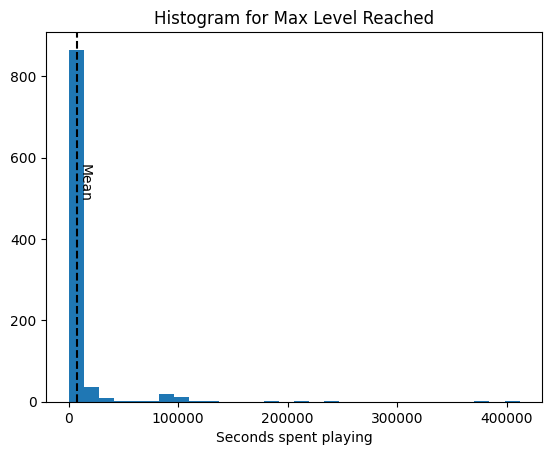

In [77]:
#jobs completed
f, ax = plt.subplots()
ax.hist(df_column, bins=30)
ax.axvline(x=df_column.mean(), linestyle='--', color='k', label="Median")
ax.text(x=df_column.mean() + 0.25, y=500, s="Mean", rotation=-90)
ax.set_xlabel("Seconds spent playing")
ax.set_title("Histogram for Max Level Reached")
print(f'The average time spent was {df_column.mean()}')

How far did the players get?

In [78]:

#@parameter
df_column = df_session['SessionJobsCompleted'] #column must be integers

The average  completed level was 3.0964360587002098


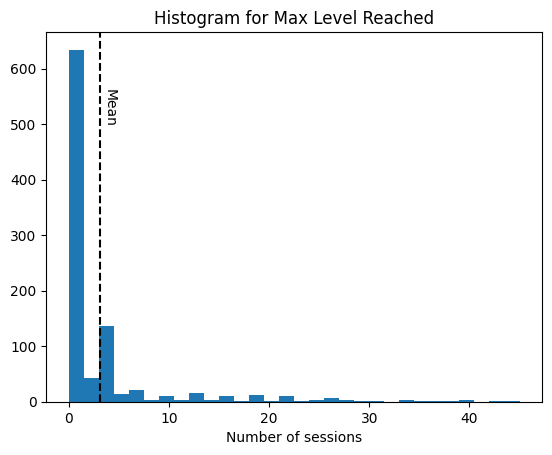

In [79]:
#jobs completed
f, ax = plt.subplots()
ax.hist(df_column, bins=30)
ax.axvline(x=df_column.mean(), linestyle='--', color='k', label="Median")
ax.text(x=df_column.mean() + 0.25, y=500, s="Mean", rotation=-90)
ax.set_xlabel("Number of sessions")
ax.set_title("Histogram for Max Level Reached")
print(f'The average  completed level was {df_column.mean()}')

X vs Y Scatter Plot

In [80]:
#scatter plot columns
col1 = 'SessionHelpCount' #@param{type:"string"}
col2 = 'SessionJobsCompleted'#@param{type:"string"}

Text(0, 0.5, 'SessionJobsCompleted')

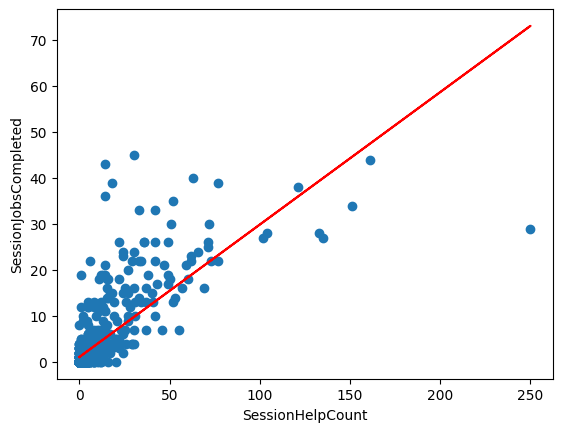

In [81]:
plt.scatter(df_session[col1], df_session[col2])
m, b = np.polyfit(df_session[col1], df_session[col2], 1)
plt.plot(df_session[col1], m*df_session[col1]+b, color = 'red')
plt.xlabel(col1)
plt.ylabel(col2)


Amount of Sessions vs Avg Length of Session

In [82]:
#scatter plot columns
col1 = 'SessionCount' #@param{type:"string"}
col2 = 'UserAvgSessionDuration'#@param{type:"string"}

Text(0, 0.5, 'UserAvgSessionDuration')

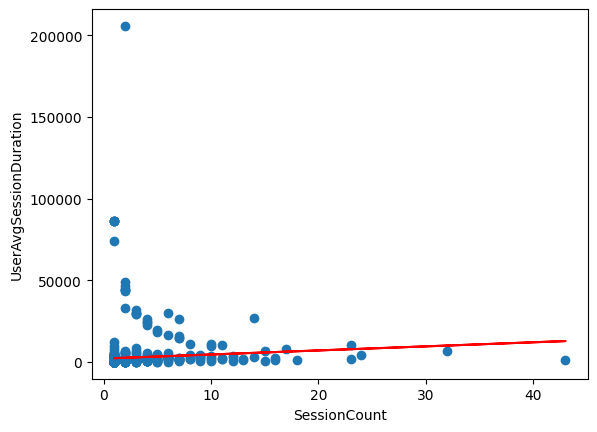

In [83]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])
m, b = np.polyfit(df_Aggregate[col1], df_Aggregate[col2], 1)
plt.plot(df_Aggregate[col1], m*df_Aggregate[col1]+b, color = 'red')
plt.xlabel(col1)
plt.ylabel(col2)

Text(0, 0.5, 'SessionJobsCompleted/UserTotalSessionDuration')

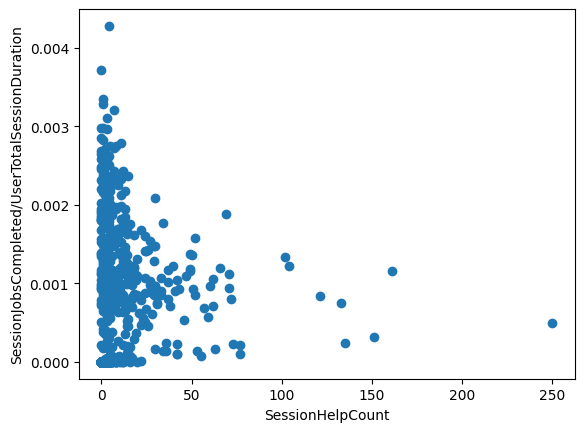

In [84]:
#scatter plot comparing help to jobs_completed/active time
plt.scatter(df_Aggregate.SessionHelpCount, df_Aggregate.SessionJobsCompleted/df_Aggregate.UserTotalSessionDuration) #ActiveTime is a str, can not be divided
plt.xlabel("SessionHelpCount")
plt.ylabel("SessionJobsCompleted/UserTotalSessionDuration")

/tmp/ipykernel_1209/3084540358.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_Aggregate[target_cols].hist(ax=ax)


array([[<Axes: title={'center': 'SessionDiveSitesCount'}>,
        <Axes: title={'center': 'SessionGuideCount'}>,
        <Axes: title={'center': 'SessionHelpCount'}>],
       [<Axes: title={'center': 'SessionJobsCompleted'}>,
        <Axes: title={'center': 'SwitchJobsCount'}>,
        <Axes: title={'center': 'UserAvgSessionDuration'}>],
       [<Axes: title={'center': 'UserTotalSessionDuration'}>, <Axes: >,
        <Axes: >]], dtype=object)

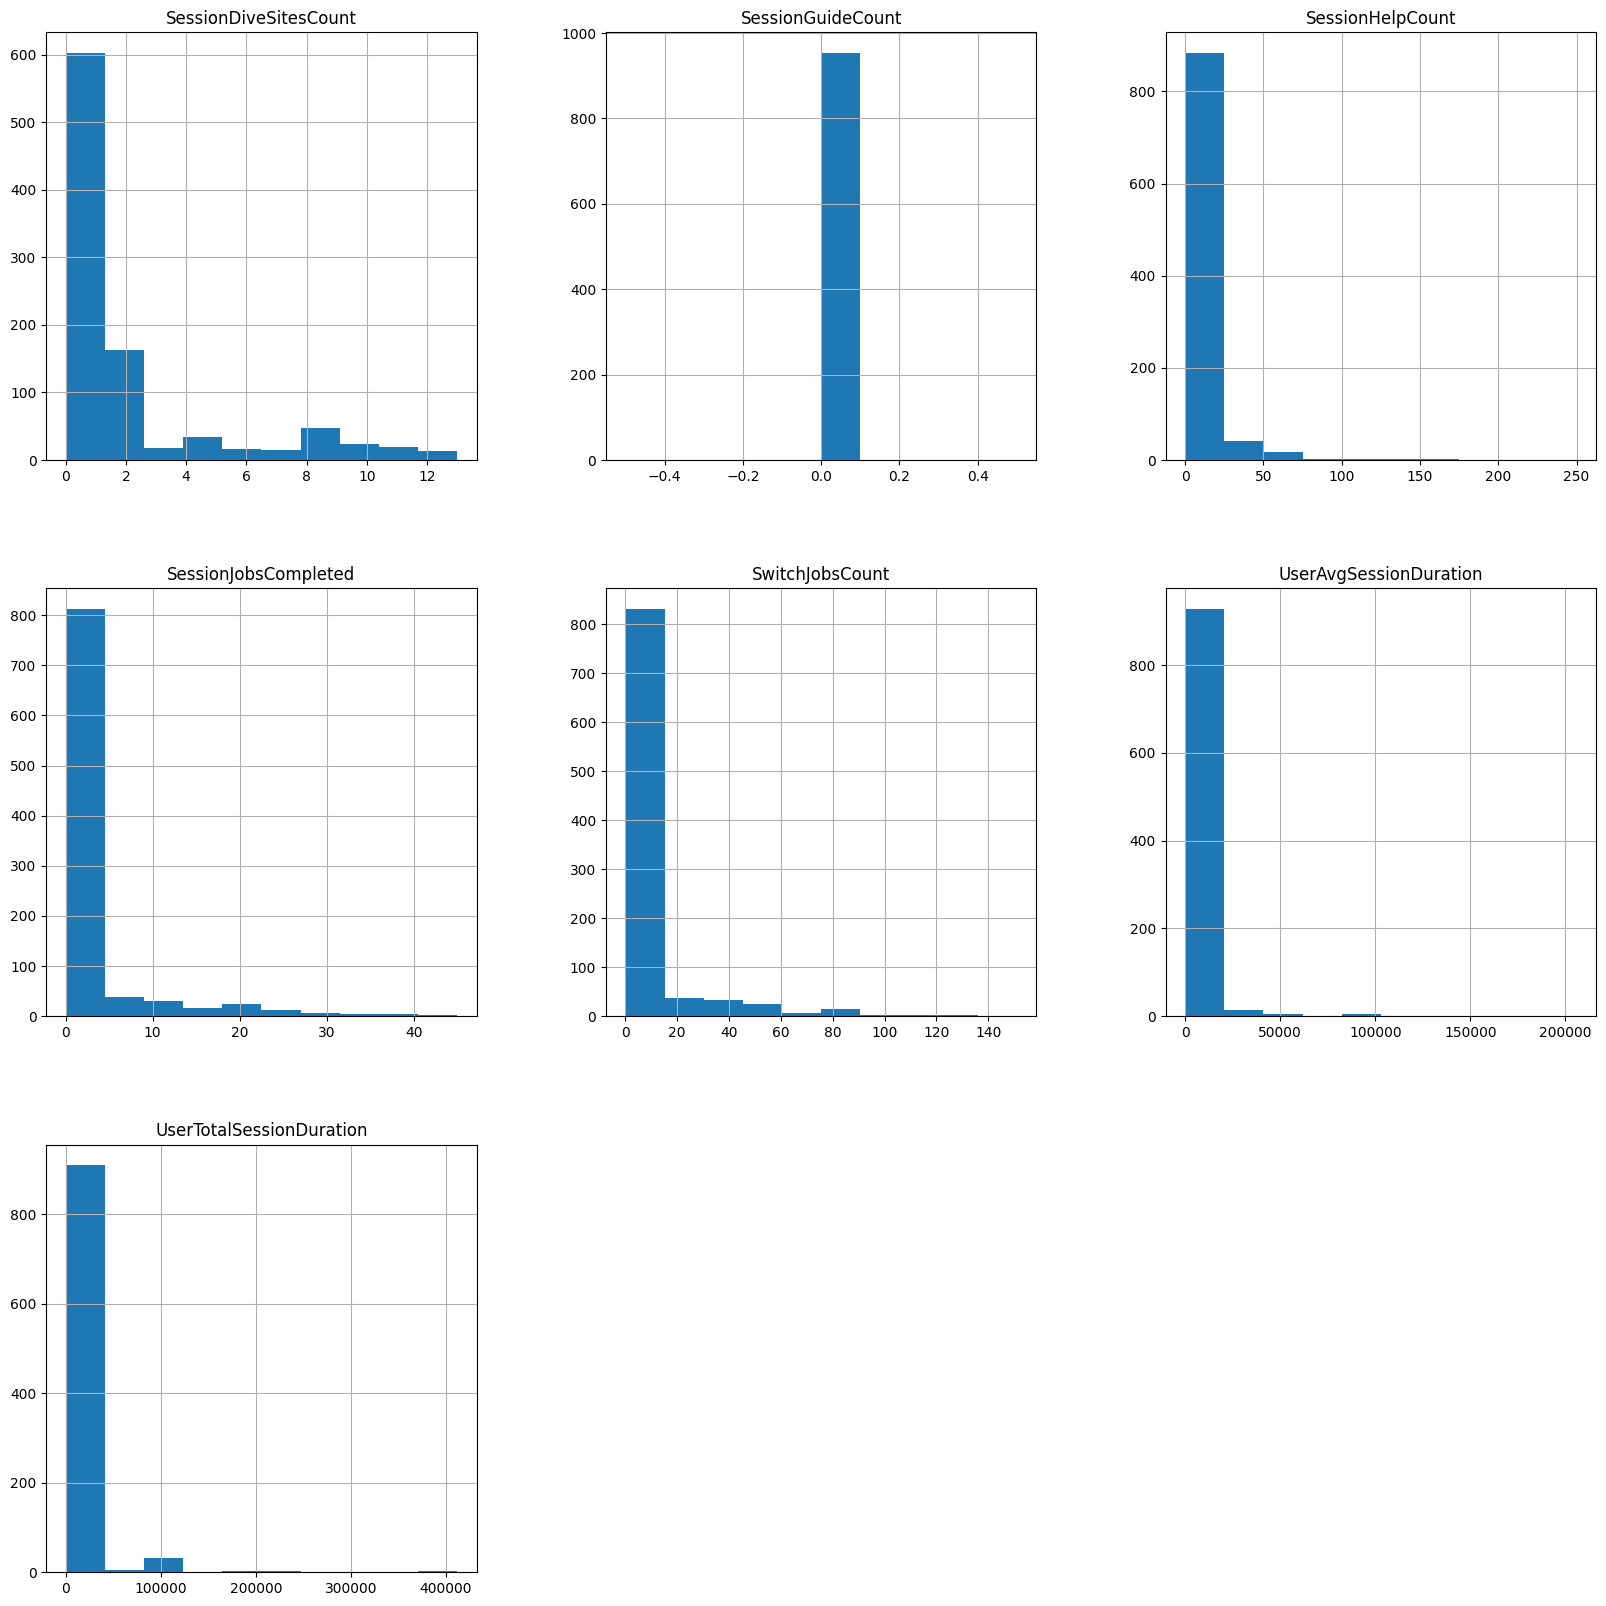

In [85]:
target_cols = ['SessionDiveSitesCount', 'SessionGuideCount', 'SessionHelpCount', 'SessionJobsCompleted', 'SwitchJobsCount', 'UserAvgSessionDuration', 'UserTotalSessionDuration']
        
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
df_Aggregate[target_cols].hist(ax=ax)

Heatmap across columns x,y,z...

<Axes: >

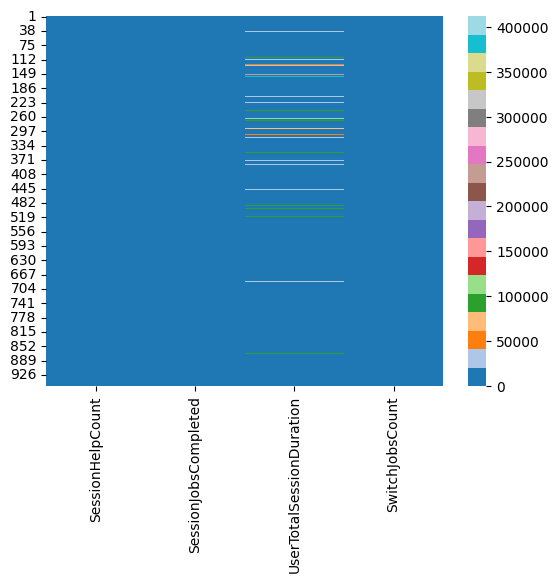

In [86]:
features1= ['SessionHelpCount','SessionJobsCompleted','UserTotalSessionDuration', 'SwitchJobsCount']

sns.heatmap(data = df_Aggregate[features1], cmap = 'tab20')

Heatmap across argumentation time

<Axes: >

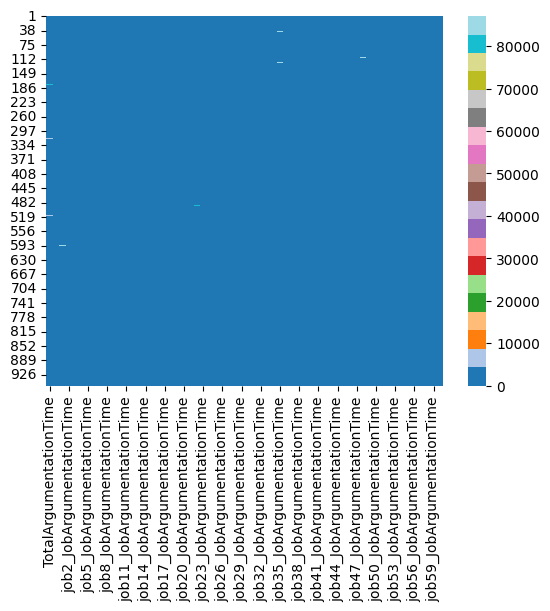

In [87]:
sns.heatmap(data = df_Interested, cmap = 'tab20')

In [88]:
outlier = 100000 #@param {type:"integer"}
target_col = 'UserAvgSessionDuration'
bigoutliers = np.where(df_Aggregate[target_col].ge(outlier)) 
#df of outliers
df_Aggregate[target_col].drop(df_Aggregate[target_col].loc[bigoutliers])


1        92.000000
2      5289.833333
3      5308.000000
4      2271.000000
5      6748.031250
          ...     
950     776.000000
951     669.000000
952    1637.500000
953    1487.000000
954      53.000000
Name: UserAvgSessionDuration, Length: 953, dtype: float64

## Some aggregate feature visualization

In [89]:
#columns to compare with scatter plot
col1 = 'SessionJobsCompleted' #@param{type:"string"}
col2 = 'SwitchJobsCount'#@param{type:"string"}

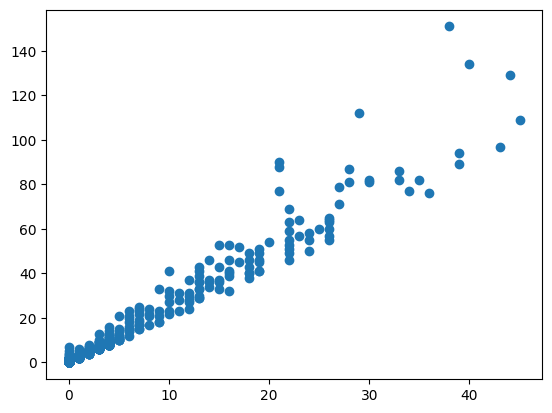

In [90]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])

In [91]:
#scatter plot columns
col1 = 'SessionHelpCount' #@param{type:"string"}
col2 = 'SessionJobsCompleted'#@param{type:"string"}

Text(0, 0.5, 'SessionJobsCompleted')

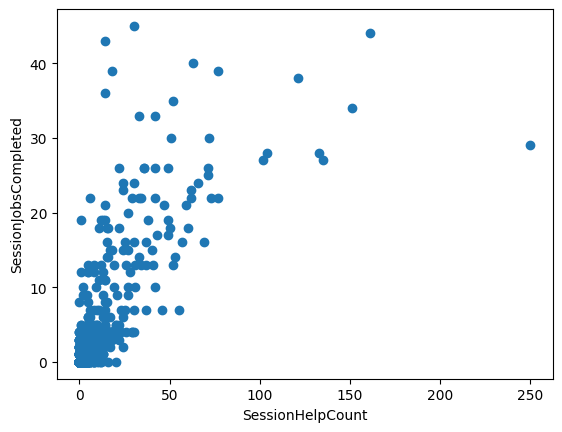

In [92]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])
plt.xlabel(col1)
plt.ylabel(col2)

You may want to see more advanced relationship via plots. Here is an example

Text(0, 0.5, 'SessionJobsCompleted/UserTotalSessionDuration')

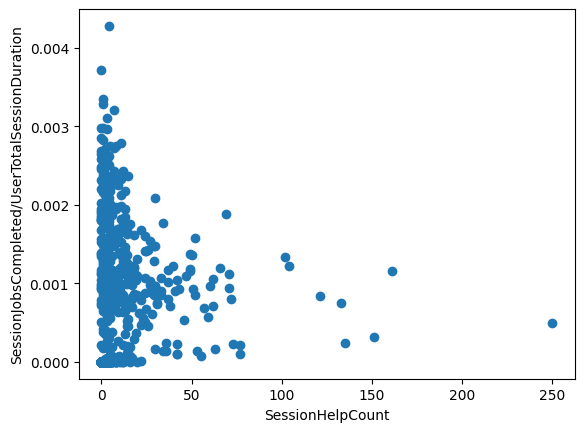

In [93]:
#scatter plot comparing help to jobs_completed/active time
plt.scatter(df_Aggregate.SessionHelpCount, df_Aggregate.SessionJobsCompleted/df_Aggregate.UserTotalSessionDuration) 
plt.xlabel("SessionHelpCount")
plt.ylabel("SessionJobsCompleted/UserTotalSessionDuration")

# Machine learning models with Scikit Learn

In [94]:
response = "SessionJobsCompleted"
predictors = ['TotalArgumentationTime', 'TotalDiveTime', 'TotalExperimentationTime']

## preprocessing

In [95]:

x = df_Aggregate[predictors].values
y = df_Aggregate[response].values
std_x = StandardScaler().fit_transform(x)
std_y = StandardScaler().fit_transform(np.array(y)[:,np.newaxis])

ValueError: could not convert string to float: '0:00:00'

## building model

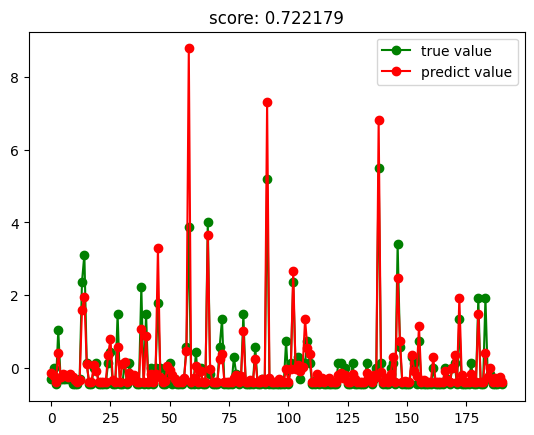

In [ ]:
#linear regression model of train vs test
model = LR()
x_train, x_test, y_train, y_test = train_test_split(std_x, std_y, test_size=0.2, shuffle=True)
model.fit(x_train, y_train)
score = model.score(x_test, y_test)
result = model.predict(x_test)
plt.figure()
plt.plot(np.arange(len(result)), y_test,'go-',label='true value')
plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
plt.title('score: %f'%score)
plt.legend()
plt.show()

## Cross validataion

In [ ]:
scores = cross_validate(model, x_train, y_train, cv=5, return_train_score=False)

print(scores.keys())
pprint(scores)

dict_keys(['fit_time', 'score_time', 'test_score'])
{'fit_time': array([0.00238419, 0.00150776, 0.00103688, 0.00113988, 0.00102568]),
 'score_time': array([0.00145578, 0.00050163, 0.00040174, 0.00033879, 0.0005374 ]),
 'test_score': array([0.73349363, 0.62243465, 0.64650076, 0.58301445, 0.77316722])}


# Deep Neural network with Keras

## Classification tasks

### Spliting data

In [ ]:
df_NN = df_Aggregate.copy()
df_NN

,index,PlayerID,SessionCount,ActiveTime,JobsCompleted,SessionDiveSitesCount,SessionGuideCount,SessionHelpCount,SessionID,SessionJobsCompleted,SwitchJobsCount,TopJobCompletionDestinations,TopJobSwitchDestinations,TotalArgumentationTime,TotalDiveTime,TotalExperimentationTime,UserAvgSessionDuration,UserTotalSessionDuration,groups
0,1,AbruptSign,1,0:01:32,[],0,0,0,player,0,0,{},{},0.0,0.0,0.0,92.0,92,False
1,2,AbsorbedComma,6,"1 day, 22:19:00","['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...",12,0,42,player,33,82,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""A...","{""no-active-job"": {""arctic-missing-whale"": [""A...",2664.0,677.0,3029.0,5289.833333,31739,True
2,3,AbstractRobin,2,"-1 day, 23:12:25","['kelp-urchin-barren-viz', 'kelp-musselfest-so...",10,0,24,player,15,36,"{""kelp-urchin-barren-viz"": {""kelp-musselfest-s...","{""no-active-job"": {""arctic-missing-whale"": [""A...",858.0,122.0,480.0,5308.0,10616,True
3,4,AccusingSonnet,5,"-3 days, 2:41:08","['arctic-seal-habitats', 'arctic-salmon-monito...",9,0,25,player,16,32,"{""arctic-salmon-monitoring"": {""coral-turtle-po...","{""no-active-job"": {""coral-turtle-population"": ...",1536.0,197.0,533.0,2271.0,11355,True
4,5,AcidHumor,32,"2 days, 6:11:09","['coral-fake-fix', 'coral-lionfish-conspiracy'...",11,0,42,player,22,69,"{""coral-fake-fix"": {""coral-lionfish-conspiracy...","{""no-active-job"": {""coral-stressed"": [""AcidHum...",4867.0,771.0,1881.0,6748.03125,215937,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,950,WatchfulGuest,1,0:05:28,[],0,0,0,player,0,2,{},{},0.0,0.0,0.0,776.0,776,False
950,951,WigglyMetro,1,0:02:11,[],0,0,0,player,0,1,{},{},0.0,0.0,0.0,669.0,669,False
951,952,WildNote,2,2:49:38,"['kelp-welcome', 'kelp-bull-kelp-forest', 'kel...",4,0,5,player,3,7,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""W...",{},264.0,104.0,168.0,1637.5,3275,True
952,953,WishfulBasics,1,0:17:28,"['kelp-welcome', 'kelp-bull-kelp-forest']",2,0,0,player,2,5,"{""kelp-welcome"": {""kelp-bull-kelp-forest"": [""W...",{},175.0,51.0,67.0,1487.0,1487,True


In [ ]:
Predictors = ['TotalArgumentationTime', 'TotalExperimentationTime',
              'SessionDiveSitesCount',
               'SessionHelpCount'] #ActiveTime not an int
Responses = ['SessionJobsCompleted', "TotalDiveTime"]
cut_value = [1, 20]

In [ ]:
for r, v in zip(Responses, cut_value):
  df_NN['group_'+r] = (df_NN[r] > v).astype(np.int)

/tmp/ipykernel_3318/2567983929.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_NN['group_'+r] = (df_NN[r] > v).astype(np.int)
/tmp/ipykernel_3318/2567983929.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated i

In [ ]:
X = df_NN[Predictors]
y = df_NN[['group_' + r for r in Responses]]
X_norm = (X - X.min())/(X.max() - X.min())
X_norm = np.asarray(X_norm).astype('float32')
y_norm = (y - y.min())/(y.max() - y.min())
x_train_full, x_test, y_train_full, y_test = train_test_split(X_norm, y_norm, test_size=0.2, shuffle=True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, test_size=0.2, shuffle=True)
x_train.shape

(610, 4)

### Training models

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=x_train.shape[1:]))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(y_train.shape[1], activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 300)               1500      
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 2)                 202       
                                                                 
Total params: 31,802
Trainable params: 31,802
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.003),
              metrics=[keras.metrics.binary_accuracy])

In [ ]:
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), batch_size=40)

Epoch 1/30
16/16 [==============================] - 2s 17ms/step - loss: 0.6863 - binary_accuracy: 0.8582 - val_loss: 0.6837 - val_binary_accuracy: 0.8301
Epoch 2/30
16/16 [==============================] - 0s 5ms/step - loss: 0.6807 - binary_accuracy: 0.8582 - val_loss: 0.6784 - val_binary_accuracy: 0.8039
Epoch 3/30
16/16 [==============================] - 0s 4ms/step - loss: 0.6752 - binary_accuracy: 0.8057 - val_loss: 0.6737 - val_binary_accuracy: 0.7712
Epoch 4/30
16/16 [==============================] - 0s 4ms/step - loss: 0.6702 - binary_accuracy: 0.7902 - val_loss: 0.6692 - val_binary_accuracy: 0.7549
Epoch 5/30
16/16 [==============================] - 0s 4ms/step - loss: 0.6655 - binary_accuracy: 0.7713 - val_loss: 0.6647 - val_binary_accuracy: 0.7353
Epoch 6/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6608 - binary_accuracy: 0.7566 - val_loss: 0.6606 - val_binary_accuracy: 0.7222
Epoch 7/30
16/16 [==============================] - 0s 4ms/step - loss: 0.6

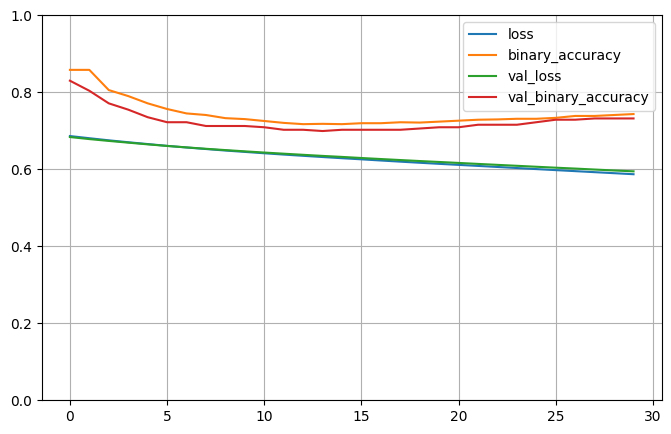

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# SOlution? REsolve

### Evaluation on the test data

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 2 samples")
predictions = model.predict(x_test[:3])
print("predictions:", predictions)
print("target_values:", y_test[:3])

Evaluate on test data
6/6 [==============================] - 0s 2ms/step - loss: 0.5694 - binary_accuracy: 0.8063
test loss, test acc: [0.5693773627281189, 0.8062826991081238]
Generate predictions for 2 samples
1/1 [==============================] - 0s 70ms/step
predictions: [[0.3519739  0.38601813]
 [0.35197467 0.38596317]
 [0.35197455 0.38596153]]
target_values:      group_SessionJobsCompleted  group_TotalDiveTime
798                         0.0                  0.0
234                         0.0                  0.0
289                         0.0                  0.0


In [ ]:
predictions = model.predict(x_test)

6/6 [==============================] - 0s 1ms/step


Take SessionJobsCompleted as an example

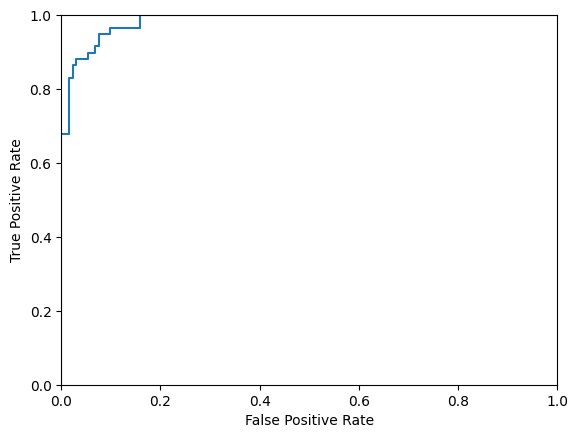

In [ ]:
fpr , tpr , thresholds = roc_curve (y_true=y_test.iloc[:,0], y_score=predictions[:,0])
plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show() 